## Question D - Custom classifier on Dataset D

In [39]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn import model_selection
from sklearn import metrics
from sklearn.utils import resample

from statistics import mode

from imblearn.over_sampling import SMOTE

from typing import Tuple


In [ ]:
# Load the training data from the `datasetC.csv` file
# We use a proportion of \@ test_size * N\@ samples for training and the rest for testing-validation.

filename = "datasetC.csv"
test_size = 0.5
labeled_data = np.loadtxt(filename, delimiter=",", dtype=np.float64)
N = labeled_data.shape[0]
D = labeled_data.shape[1] - 1
K = len(np.unique(labeled_data[:, D]))

train_set, test_set = model_selection.train_test_split(labeled_data, test_size=test_size, shuffle=True, random_state=0)
X_train, y_train = train_set[:, 0:D], train_set[:, D].astype(int)
X_test, y_test = test_set[:, 0:D], test_set[:, D].astype(int)
N_train, N_test = y_train.shape[0], y_test.shape[0]

In [ ]:
'''
Data playground:
Here we experiment with the properties of the dataset, in an attempt to determine the most suitable classifier.
'''

X = labeled_data[:, 0:D]
Y = labeled_data[:, D]

'''
First, check whether we could use PCA. We wil check how many components we need to keep,
in order to maintain 90% of the explained variance.
'''
variance_ratio = 0.9
C = np.cov(X, rowvar=False) # `rowvar=False`: each row of X is a sample
ev = np.linalg.eigvals(C)

total_var = np.sum(ev)
explained_var = 0.0
nc = 0 # number of components to keep
ratio = 0.0

for i in range(D):
    explained_var += ev[i]
    ratio = explained_var / total_var
    if ratio >= variance_ratio:
        nc = i
        print(f" > Number of components : {nc}, explaining {ratio:.3f} of the total variance.")
        break

'''
The number of components is too high to bother transforming thre data.
The explained variance is equally distributed amongst almost all features.
So, we have no concrete way to visualize the data.
********************
Now, we will check whether we can improve our data by scaling, or normalizing it.
We will check the means and variances for all 400 features.
'''
means = np.mean(X, axis=0) # the mean across all columns
plt.hist(means)
plt.hist(np.diag(C))
# There's no scaling that needs to be done, since all features are in the same order of magnitude.

In [ ]:
'''
Creating a class like the one used in Question C.
Will be used in order to store information on the hyperparameters
of the model that was considered the best one after an atypical grid search.
'''
class MLP_training_info:
    # Use sklearn's default values.
    def __init__(
        self, *,
        hidden_layer_sizes: Tuple[int] = (100),
        activation: str = "relu",
        solver: str = "adam",
        learning_rate: str = "constant",
        learning_rate_init: float = 0.001,
        tol: float = 1.e-4,
        momentum: float = 0.9
    ):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.tol = tol
        self.momentum = momentum

    def __str__(self):
        s = (f"{self.hidden_layer_sizes}, f={self.activation}, s={self.solver}, "
            f"eta={self.learning_rate_init}|{self.learning_rate}, "
            f"tol={self.tol}, m={self.momentum}")
        return s

In [ ]:
'''
Uses the custom MLP training parameter class in order to pass the values
to sklearn's MLPClassifier module.
'''
def train_mlp(X_train, y_train, info: MLP_training_info) -> MLPClassifier:
    model = MLPClassifier(
        activation=info.activation,
        solver=info.solver,
        learning_rate=info.learning_rate,
        learning_rate_init=info.learning_rate_init,
        tol=info.tol,
        momentum=info.momentum,
        shuffle=False
    )
    model.fit(X_train, y_train)
    return model

'''
Trains an MLP using the parameters stored in \@ info \@.
Displays the confustion matrix and the accuracy of the model,
along with the utilized parameters.
'''
def test_params(
    X_train: np.ndarray, y_train: np.ndarray,
    X_test: np.ndarray, y_test: np.ndarray, info: MLP_training_info
):
    model = train_mlp(X_train, y_train, info)
    y_pred = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_plot = metrics.ConfusionMatrixDisplay(cm)
    cm_plot.plot()
    cm_plot.ax_.set_title(info.__str__())
    print(f"{info}: {metrics.accuracy_score(y_test, y_pred)}")

In [ ]:
# Split the testing dataset in half.
# First half will remain the testing data, second half will be used for validation.
Nt = int(N_test / 2)
Nv = N_test - Nt
X_testc, y_testc = X_test[:, 0:Nt], y_test[0:Nt]
X_validate, y_validate = X_test[:, Nt:], y_test[Nt:]

In [ ]:
info = MLP_training_info(
    hidden_layer_sizes = [int(3*D/2), int(2*D/3)],
    learning_rate_init = 0.005,
    learning_rate = "adaptive",
    solver = "sgd"
)

info.solver = "lbfgs"
test_params(X_train, y_train, X_test, y_test, info)

info.hidden_layer_sizes = (int(D/2), int(D/2))
test_params(X_train, y_train, X_test, y_test, info)

info.activation = "logistic"
test_params(X_train, y_train, X_test, y_test, info)

info.learning_rate_init = 0.001
test_params(X_train, y_train, X_test, y_test, info)

info.learning_rate = "constant"
test_params(X_train, y_train, X_test, y_test, info)

info.learning_rate = "invscaling"
test_params(X_train, y_train, X_test, y_test, info)

info.activation = "tanh"
test_params(X_train, y_train, X_test, y_test, info)

info.activation = "logistic"
info.tol = 1.e-5
test_params(X_train, y_train, X_test, y_test, info)

info.hidden_layer_sizes = (D)
info.tol = 5.e-3
info.momentum = 0.95
test_params(X_train, y_train, X_test, y_test, info)

info.activation = "relu"
test_params(X_train, y_train, X_test, y_test, info)

info.hidden_layer_sizes = ((int(D/2), D, int(D/2)))
test_params(X_train, y_train, X_test, y_test, info)

info.learning_rate = "adaptive"
info.tol = 1.e-4
test_params(X_train, y_train, X_test, y_test, info)

info.activation = "logistic"
test_params(X_train, y_train, X_test, y_test, info)

info.solver = "adam"
test_params(X_train, y_train, X_test, y_test, info)

In [ ]:
'''
Testing the application of a K-Neighbors classifying approach.
'''

model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_plot = metrics.ConfusionMatrixDisplay(cm)
cm_plot.plot()
print(metrics.accuracy_score(y_test, y_pred))

model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_plot = metrics.ConfusionMatrixDisplay(cm)
cm_plot.plot()
print(metrics.accuracy_score(y_test, y_pred))

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_plot = metrics.ConfusionMatrixDisplay(cm)
cm_plot.plot()
print(metrics.accuracy_score(y_test, y_pred))

In [ ]:
'''
Trying using an SVC on the data.
'''

svmc = SVC(kernel="rbf")
svmc.fit(X_train, y_train)
y_pred = svmc.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_plot = metrics.ConfusionMatrixDisplay(cm)
cm_plot.plot()
print(metrics.accuracy_score(y_test, y_pred))

svmc = SVC(C=10, kernel="rbf")
svmc.fit(X_train, y_train)
y_pred = svmc.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_plot = metrics.ConfusionMatrixDisplay(cm)
cm_plot.plot()
print(metrics.accuracy_score(y_test, y_pred))

sm = SMOTE(random_state=0)
X_train_ovs, y_train_ovs = sm.fit_resample(X_train, y_train)

svmc = SVC(kernel="rbf")
svmc.fit(X_train_ovs, y_train_ovs)
y_pred = svmc.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_plot = metrics.ConfusionMatrixDisplay(cm)
cm_plot.plot()
print(metrics.accuracy_score(y_test, y_pred))

svmc = SVC(C=10, kernel="rbf")
svmc.fit(X_train_ovs, y_train_ovs)
y_pred = svmc.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_plot = metrics.ConfusionMatrixDisplay(cm)
cm_plot.plot()
print(metrics.accuracy_score(y_test, y_pred))

In [ ]:
'''
Next test :
Training a number of `2 * K` classifiers, by using resampling.
Reminder : K is the number of classes in the dataset.
'''

nclassifiers = 2 * K
nsamples = int(3 * N_train / nclassifiers)
models = []
info = MLP_training_info(
    hidden_layer_sizes=(int(D/2), int(D/2)),
    activation="logistic",
    solver="lbfgs",
    learning_rate="adaptive"
)

for i in range(nclassifiers):
    bs_X_train, bs_y_train = resample(X_train, y_train, replace=False, n_samples=nsamples, random_state=42)
    m = train_mlp(bs_X_train, bs_y_train, info)
    models.append(m)

In [ ]:
y_pred = np.zeros((nclassifiers, N_test))
for i in range(nclassifiers):
    y_pred[i, :] = models[i].predict(X_test)

total_y_pred = np.zeros((N_test))
for i in range(N_test):
    total_y_pred[i] = mode(y_pred[:, i])

cm = metrics.confusion_matrix(y_test, total_y_pred)
cm_plot = metrics.ConfusionMatrixDisplay(cm)
cm_plot.plot()
print(metrics.accuracy_score(y_test, total_y_pred))



In [46]:
'''
Out of the test we conducted, the best accuracy score we get is: 0.8456
Parameters used for training the *SVC*:
  <ul>
    <li> Kernel : RBF </li>
    <li> C : 10 </li>
  </ul>
*******************
We will conduct a final grid search around the neighbourhood of the best value for C.
'''

nparams = 9
c = [8 + 0.5 * i for i in range(nparams)]
best_acc = 0.0
best_c = 8

# Validation set creation for the grid search
X_test_star, X_validate, y_test_star, y_validate = model_selection.train_test_split(
    X_test, y_test, test_size=0.5, shuffle=False, random_state=0
)

for i in range(nparams):
    c_i = c[i]
    model_i = SVC(kernel="rbf", C=c_i)
    model_i.fit(X_train, y_train)
    pred_i = model_i.predict(X_validate)
    acc_i = metrics.accuracy_score(y_validate, pred_i)
    if acc_i > best_acc:
        best_c = c_i
        best_acc = acc_i

print(f"  >> Best C : {best_c}, accuracy: {best_acc}")

  >> Best C : 8.0, accuracy: 0.848


Text(0.5, 1.0, 'RBF SVC, C = 8.0')

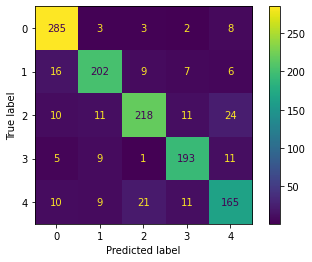

In [48]:
best_svc = SVC(C=best_c, kernel="rbf")
best_svc.fit(np.vstack((X_train, X_validate)), np.concatenate((y_train, y_validate)))
y_pred = best_svc.predict(X_test_star)
cm_svc = metrics.confusion_matrix(y_test_star, y_pred)
cms_plot = metrics.ConfusionMatrixDisplay(cm_svc)
cms_plot.plot()
cm_plot.ax_.set_title(f"RBF SVC, C = {best_c}")